### Experiment: skip window 2048 characters, max skips 5/10/15, max amb level 1

#### Max 5 skips:
- Parse errors: 3.54% -> 4.03%
- Error counts avg: 1.37 -> 1.68
- Error size avg: 412 -> 377
- Slow parses (x10 parse time): 0.41% -> 0.25%
- New successful recoveries < 2048: 92.07% (2.83% unsuccessful)
- Old successful recoveres < 25%: 81.20% (13.91% unsuccessful)
- Total time to run tests: 48 hour -> 32 hour
- "Problematic" PreferAvoid test duration: 2500 ms -> 6 ms (was 17 hour before max amb filtering :-))

Note: as "max skip window" and "succesful recovery limit" are currently both set to 2048, the only reasons for
unsuccesful recoveries are:
- Continuation token that starts just before the 2048 boundery and crosses it
- Multiple errors that together add up to more than 2048 characters

#### max 10 skips:
- Parse errors 4.03 -> 4.13
- Error count average: 1.68 -> 1.54
- Error size average: 377 -> 373
- Slow parses: 0.25% -> 0.25%
- Successful recoveries: 92.07% -> 92.01%

#### max 15 skips:
- Parse erorers -> 4.03 -> 4.25
- Error count avg: 1.68 -> 1.45
- Error size avg: 377 -> 396
- Slow parses: 0.25% -> 0.19%
- Succesfull recoveries: 92.07% -> 91.87%


Prepare data

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import gzip
import urllib
import os.path

sns.set_theme()

statDir = "D:/stats/"


def downloadData(version, host="test", syntax="rascal", testid="rascal", minSize=0, maxSize=10240, skipLimit=3, skipWindow=2048, recovLimit=50, sampleWindow=1, seed=0):
    path = "stats/" + syntax + "/" + testid + "/stats-" + version + "-minsize-" + str(minSize) + "-maxsize-" + str(maxSize) + ":skip-limit=" + str(skipLimit) + ",skip-window=" + str(skipWindow) + ",recov-limit=" + str(recovLimit) + ",sample-window=" + str(sampleWindow) + ",seed=" + str(seed) + ".txt"
    
    cachedFile = statDir + "/cache/" + path + ".gz"
    if (not os.path.isfile(cachedFile)):
        print("Downloading file " + path + " from " + host)
        os.system("scp root@" + host + ":~/" + path + " " + cachedFile)
        os.system("gzip " + cachedFile)

    return readData(cachedFile + ".gz")
    

def readData(file):
    dtypes={
        'nodes':float
    }

    path = statDir + file
    if (file.endswith(".gz")):
        fd = gzip.open(path, 'rb')
    else:
        fd = open(path, 'rb')

    data = pd.read_csv(fd, dtype=dtypes)

    recovered = data[data["result"] == "recovery"].sort_values("size")
    range = np.arange(0, 11264, 1024)
    recovered["bsize"] = pd.cut(recovered["size"], range, labels=range[1:])

    return recovered


#recovered_old = readData("benchmark-stats-2025-04-29-flattener-amb-filter-rascal-0-10240maxamb-1.txt.gz")
recovered_old = readData("benchmark-stats-2025-05-10-skip-window-rascal-0-10240skip-5-2048.txt.gz")
#recovered = stats.readData("benchmark-stats-2025-04-19-parent-amb-3-rascal-0-10240.txt.gz")
#recovered = stats.readData("benchmark-stats-2025-04-23-parent-amb-2-rascal-0-10240.txt.gz")
#recovered = stats.readData("benchmark-stats-2025-04-23-parent-amb-any-3-rascal-0-10240.txt.gz")

# Read data at different pruning levels
maxSkips = [5]
recoveryLimits = [30,50]
recovered = []
descriptions = []
for maxSkip in maxSkips:
    for recoveryLimit in recoveryLimits:
        df = readData("benchmark-stats-2025-05-13-recov-limit-rascal-0-10240skip-" + str(maxSkip) + "-2048-" + str(recoveryLimit) + ".txt.gz")
        #df = readData("benchmark-stats-2025-05-10-skip-window-rascal-0-10240skip-" + str(maxSkip) + "-2048.txt.gz")
        #df = readData("benchmark-stats-2025-05-06-flattener-amb-filter-rascal-0-5120maxamb-" + str(pruneLevel) + ".txt.gz")
        recovered.append(df)
        descriptions.append("maxSkip=" + str(maxSkip) + ", recovLimit=" + str(recoveryLimit))
count = len(recovered)

### Visualize the recovery duration per file size bucket.

duration of maxSkip=5, recovLimit=30
count    885872.000000
mean         52.344935
std          43.624285
min           0.000000
25%          21.000000
50%          44.000000
75%          74.000000
max        3430.000000
Name: duration, dtype: float64
duration of maxSkip=5, recovLimit=50
count    885872.000000
mean         52.369786
std          43.983548
min           0.000000
25%          21.000000
50%          43.000000
75%          74.000000
max        3590.000000
Name: duration, dtype: float64


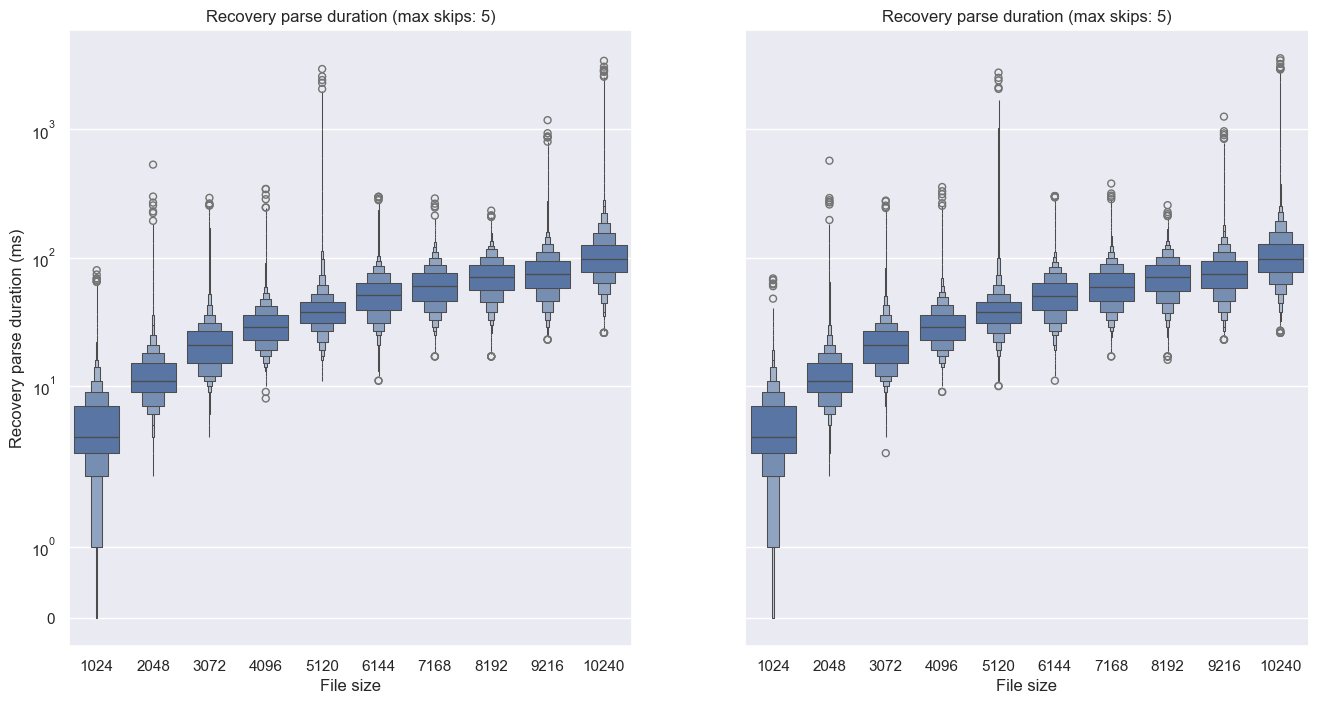

In [ ]:
durationFig, durationAx = plt.subplots(1, count, figsize=(count*8, 8), sharey=True)
durationAx[0].set_yscale('symlog')

for i in range(0, count):
    description = descriptions[i]
    print("duration of " + description)
    print(recovered[i]["duration"].describe())

    sns.boxenplot(
        data=recovered[i],
        x="bsize", y="duration",
        width_method="exponential",
        ax = durationAx[i]
    )
    durationAx[i].set_title("Recovery parse duration (max skips: " + str(maxSkips[0]) + ")")
    durationAx[i].set_xlabel("File size")
    durationAx[i].set_ylabel("Recovery parse duration (ms)")


plt.show(durationFig)

### Node distribution per file size

nodes of maxSkip=5, recovLimit=30
count    8.858720e+05
mean     2.190667e+04
std      3.015650e+04
min      3.700000e+01
25%      9.935000e+03
50%      1.880700e+04
75%      2.946600e+04
max      7.876275e+06
Name: nodes, dtype: float64
nodes of maxSkip=5, recovLimit=50
count    8.858720e+05
mean     2.190667e+04
std      3.015650e+04
min      3.700000e+01
25%      9.935000e+03
50%      1.880700e+04
75%      2.946600e+04
max      7.876275e+06
Name: nodes, dtype: float64


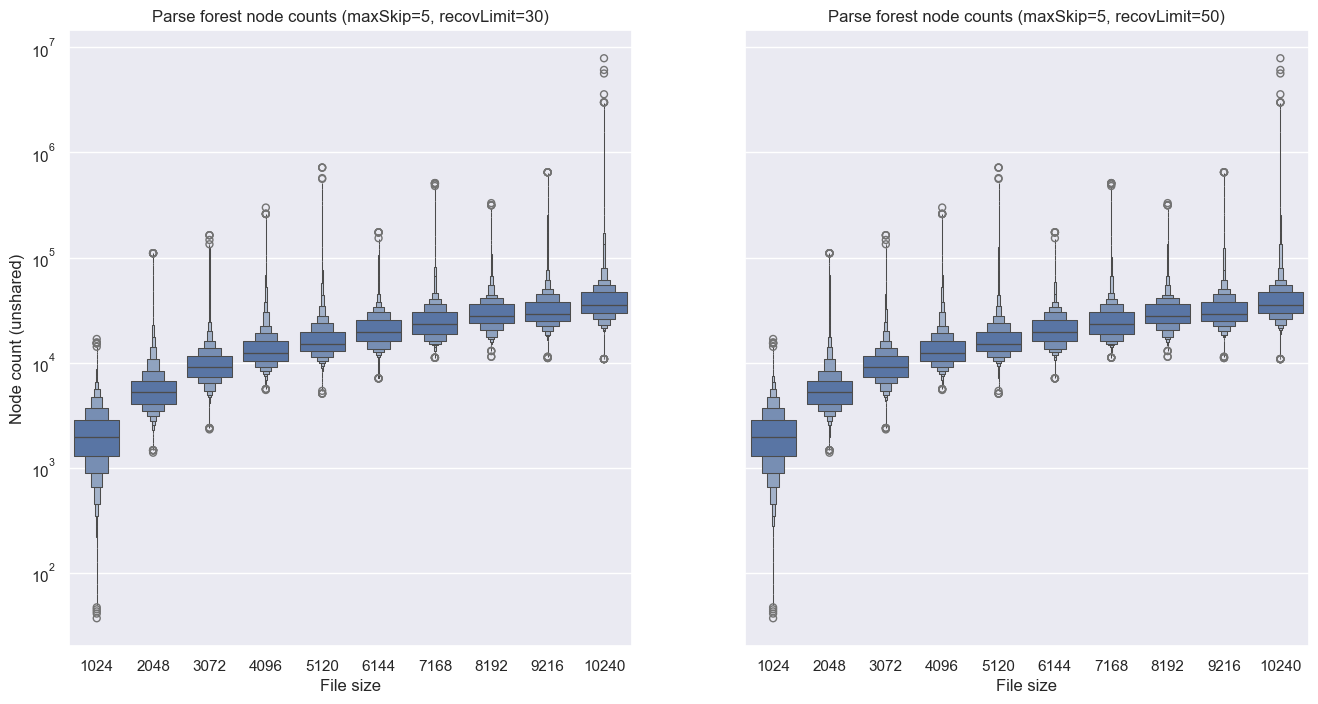

In [10]:
nodeFig, nodeAx = plt.subplots(1, count, figsize=(8*count, 8), sharey=True)
nodeAx[0].set_yscale('symlog')

for i in range(0, count):
    description = descriptions[i]
    print("nodes of " + description)
    print(recovered[i]["nodes"].describe())

    sns.boxenplot(
        data=recovered[i],
        x="bsize", y="nodes",
        width_method="exponential",
        ax=nodeAx[i]
    )

    nodeAx[i].set_title("Parse forest node counts (" + description + ")")
    nodeAx[i].set_xlabel("File size")
    nodeAx[i].set_ylabel("Node count (unshared)")


#sns.violinplot(
#    data=recovered[2],
#    x="bsize", y="nodes",
#    density_norm="width",
#    ax=ax2
#)

plt.show(nodeFig)

### Parse time ratio vs file size

count    885872.000000
mean        182.544642
std          97.780278
min           0.000000
25%         132.000000
50%         160.000000
75%         204.000000
max        7378.000000
Name: durationRatio, dtype: float64


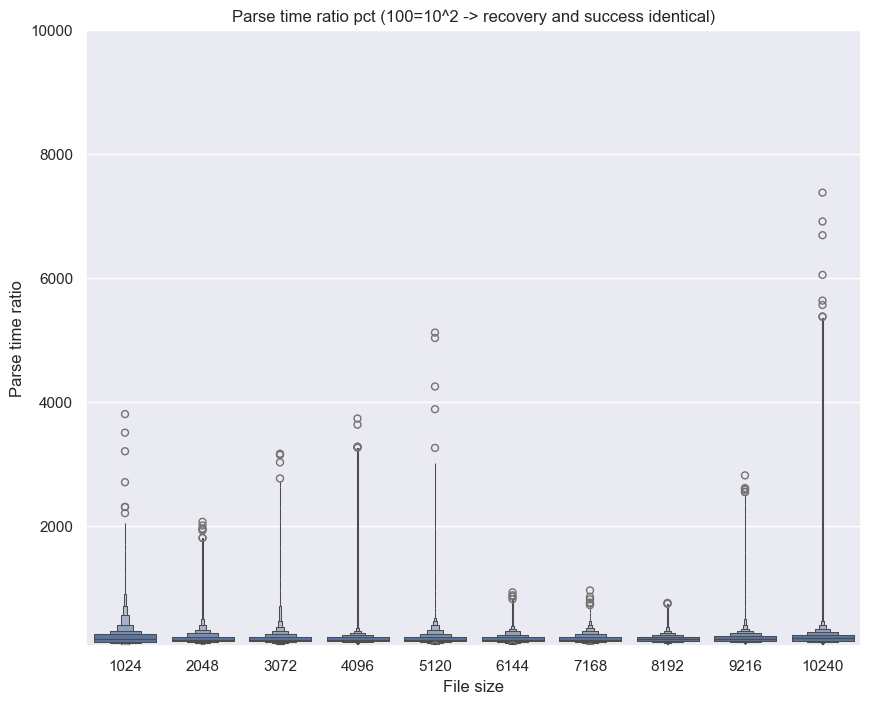

In [ ]:
print(recovered[0]["durationRatio"].describe())

durationRatioFig, durationRatioAx = plt.subplots(figsize=(10, 8))

sns.boxenplot(
    data=recovered[0],
    x="bsize", y="durationRatio",
    width_method="exponential",
    ax=durationRatioAx
)

durationRatioAx.set_yscale('symlog')

durationRatioAx.set_title("Parse time ratio pct (100=10^2 -> recovery and success identical)")
durationRatioAx.set_xlabel("File size")
durationRatioAx.set_ylabel("Parse time ratio")
durationRatioAx.set_ylim(50, 10000)
plt.show(durationRatioFig)


### Node count ratio vs file size

count    885872.000000
mean        144.938453
std         132.449850
min          20.000000
25%         103.000000
50%         127.000000
75%         161.000000
max       33605.000000
Name: nodeRatio, dtype: float64


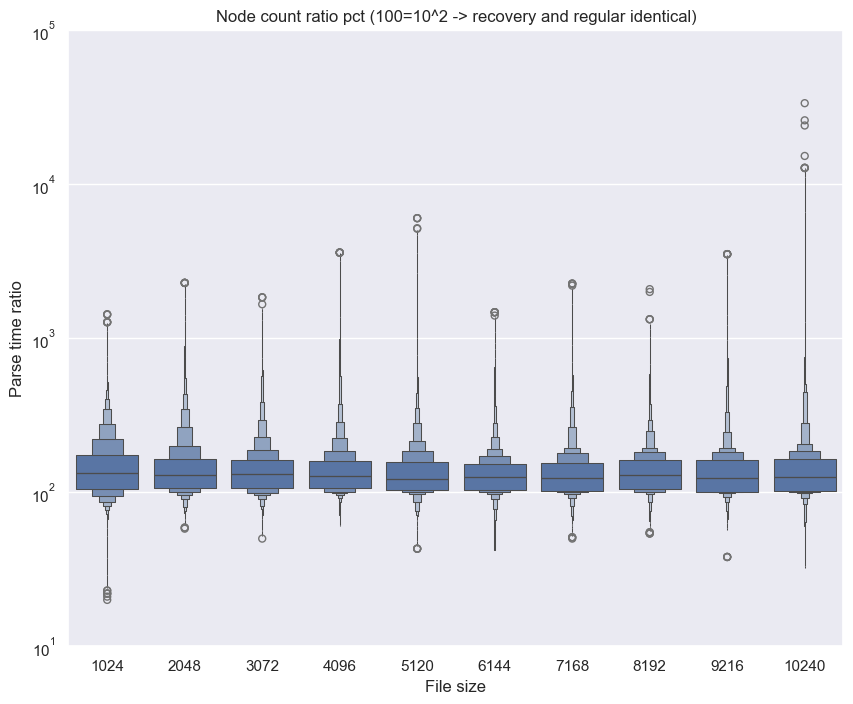

In [46]:
print(recovered[0]["nodeRatio"].describe())

nodeRatioFig, nodeRatioAx = plt.subplots(figsize=(10, 8))

sns.boxenplot(
    data=recovered[0],
    x="bsize", y="nodeRatio",
    width_method="exponential",
    ax=nodeRatioAx
)

nodeRatioAx.set_yscale('symlog')
nodeRatioAx.set_title("Node count ratio pct (100=10^2 -> recovery and regular identical)")
nodeRatioAx.set_xlabel("File size")
nodeRatioAx.set_ylabel("Parse time ratio")
nodeRatioAx.set_ylim(10, 100000)

plt.show(nodeRatioFig)



### Error recovery duration histogram

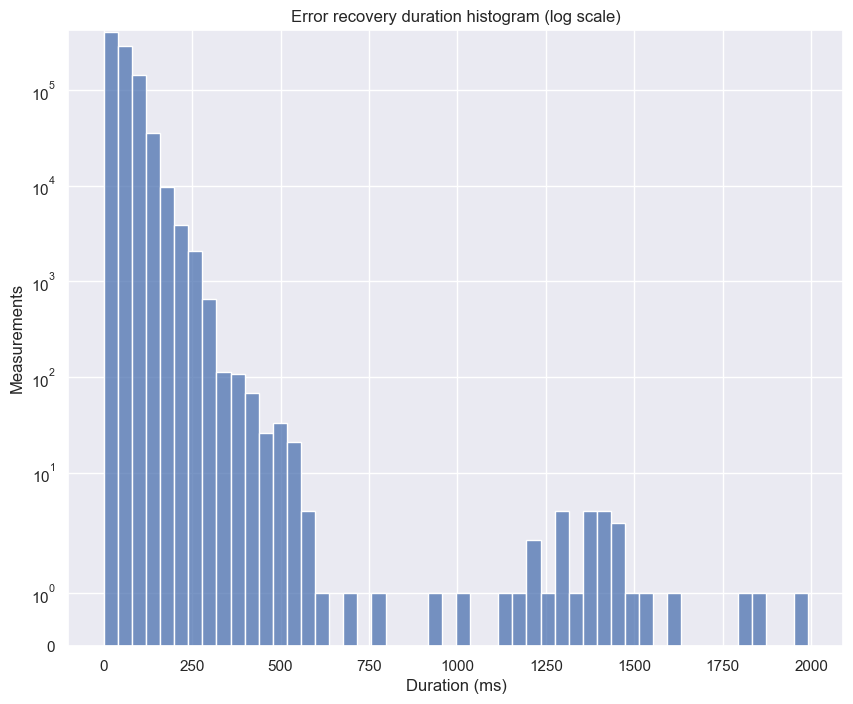

In [ ]:
durationHistFig, durationHistAx = plt.subplots(figsize=(10, 8))

sns.histplot(
    data=recovered[0],
    x="duration", stat="count",
    bins=50,
    ax=durationHistAx
)

durationHistAx.set_yscale('symlog')
durationHistAx.set_title("Error recovery duration histogram (log scale)")
durationHistAx.set_xlabel("Duration (ms)")
durationHistAx.set_ylabel("Measurements")
#durationHistAx.set_ylim(10, 100000)

plt.show(durationHistFig)

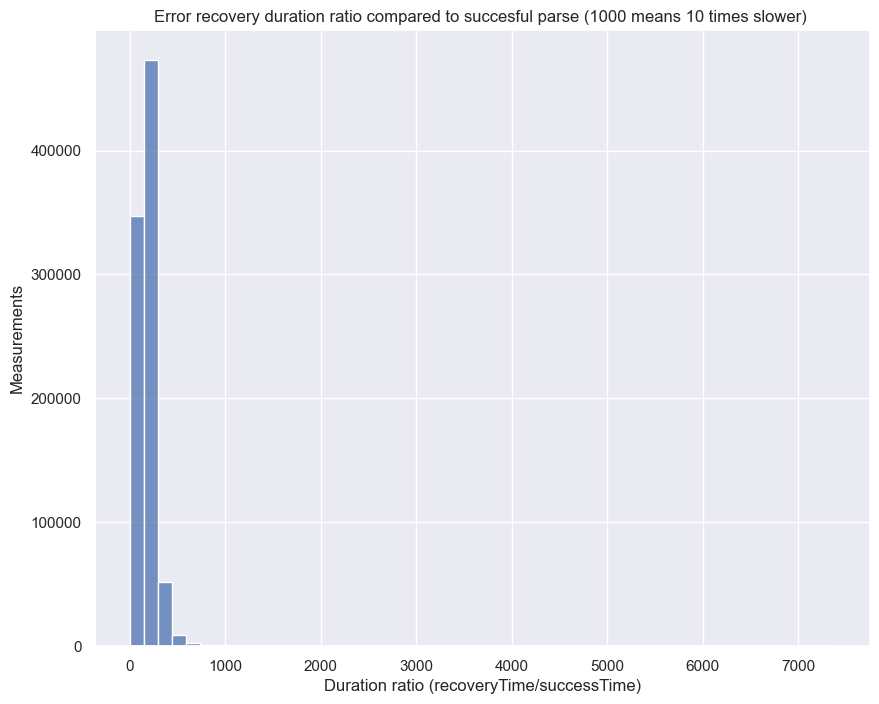

In [ ]:
durationRatioHistFig, durationRatioHistAx = plt.subplots(figsize=(10, 8))

sns.histplot(
    data=recovered[0],
    x="durationRatio", stat="count",
    bins=50,
    ax=durationRatioHistAx
)

durationRatioHistAx.set_yscale('symlog')
durationRatioHistAx.set_title("Error recovery duration ratio compared to succesful parse (1000 means 10 times slower) ")
durationRatioHistAx.set_xlabel("Duration ratio (recoveryTime/successTime)")
durationRatioHistAx.set_ylabel("Measurements")

plt.show(durationRatioHistFig)